In [126]:
%matplotlib inline

import numpy as np
import os
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.stats as ss
import miscFuns as mf #python functions we wrote

#Global variables
numDictSounds = 10

def loadAudioCalcSTFT(queryfile, sr=22050, hop_size=512, win_size=2048): #add in sample rate, hop size, window size stuff later
    ''' TO DO
    '''
    y, sr = lb.core.load(queryfile, sr=sr)
    S = lb.core.stft(y, n_fft=win_size, hop_length=hop_size)
    Smag = np.abs(S)
    return y, sr, Smag #we only use Smag

def obtainObservations(audio, sr = 22050, backtrack=1000, model=False):
    ''' TO DO
    '''
    
    #get tempo
    tempo_bpm = lb.beat.tempo(audio, sr=sr)
    tempo_bpm = int(round(tempo_bpm[0]))
    print("Tempo in bpm: ", tempo_bpm)
    
    #correct for rec1 error:
    if tempo_bpm == 30:
        print('Tempo miscalculated (=30), multiplying by 4')
        tempo_bpm *= 4
    
    #determine eighth measure window size in samples
    tempo_bps = tempo_bpm/60.0
    quarterMeasure = 1/tempo_bps #time period for 1 beat, i.e. a quarter measure
    eighthMeasure = quarterMeasure/2
    win_size = int(round(eighthMeasure*sr)) #get window size in samples
    print("8th measure window size:", win_size)
    
    #set librosa peak picker parameters
    premax = int((win_size/2.0)/512.0)
    postmax = int((win_size/2.0)/512.0)
    preavg = int((win_size/2.0)/512.0)
    postavg = int((win_size/2.0)/512.0)
    delta = 6.5
    wait = int((win_size/2.0)/512.0)
    
    #compute onset envelope for audio and then use librosa peak picker to get beat locations
    oenv = lb.onset.onset_strength(audio, sr=sr)
    plt.figure(1)
    plt.plot(oenv[:500])
    plt.show()
    beats_frames = lb.util.peak_pick(oenv, pre_max=premax, post_max=postmax, pre_avg=preavg, post_avg=postavg, delta=delta, wait=wait)
    
    #convert to samples
    beats = lb.frames_to_samples(beats_frames)
    
    #create observations array
    if model == True: 
    #we hard-code size of obsvArray to be 40 for model training, because all our training data contains 40 known observations
    #this would be addressed in future iterations
        numObsv = 40 
    else:
        numObsv = numObsv = beats.shape[0]
    obsvArray = np.zeros((win_size, numObsv))
    for i in range(numObsv):
        if i < beats.shape[0]:
            onset = beats[i]
        else:
            onset = beats[-1] #imperfect solution to cases where we get <40 observations, we never hit this case if model==False
        
        #using backtrack parameter, obtain an observation from the input audio by taking a window of size win_size, starting at onset-backtrack
        obsvArray[:,i] = audio[onset-backtrack:onset+win_size-backtrack]
    
    return tempo_bpm, beats, obsvArray

In [135]:
#use this to set queryfile from data and listen to audio
queryfile = 'audio_data/mhapte-selassie_rec1.wav'
ipd.Audio(queryfile)

Tempo in bpm:  117
8th measure window size: 5654


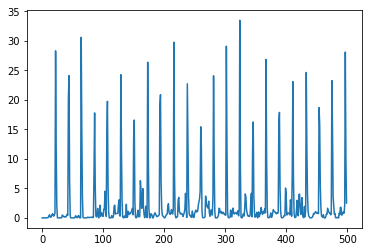

[ 11264  22528  32768  44032  54784  66048  77312  88576  99328 110592
 121856 133120 143872 154624 165888 177152 187904 199168 210432 221696
 232448 243200 254464 265728 277504 288256 299008 345600 354816 365568
 375808 387584 398848 410112 421376 431616 442368 452608 465920 476672]
numObsv: 41
[11264. 10240. 11264. 10752. 11264. 11264. 11264. 10752. 11264. 11264.
 11264. 10752. 10752. 11264. 11264. 10752. 11264. 11264. 11264. 10752.
 10752. 11264. 11264. 11776. 10752. 10752. 46592.  9216. 10752. 10240.
 11776. 11264. 11264. 11264. 10240. 10752. 10240. 13312. 10752.]


In [136]:
#Get observations from audio
audio, sr, Smag = loadAudioCalcSTFT(queryfile)
tempo, beats, obsvArray = obtainObservations(audio)
print(beats)
print('numObsv:',obsvArray.shape[1]+1)
diff = np.zeros(beats.shape[0]-1)
for i in range(beats.shape[0]-1):
    diff[i] = beats[i+1] - beats[i]
print(diff)

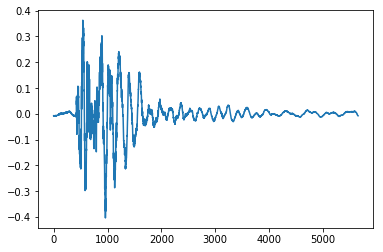

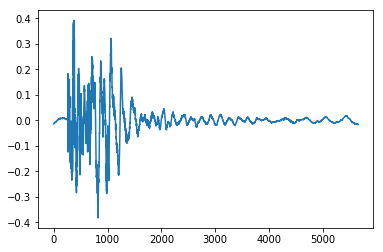

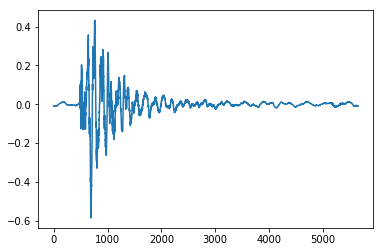

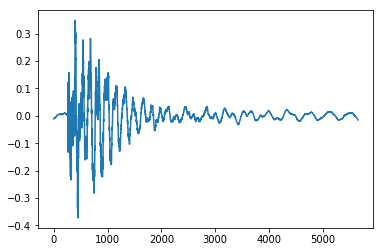

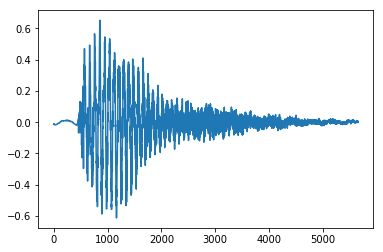

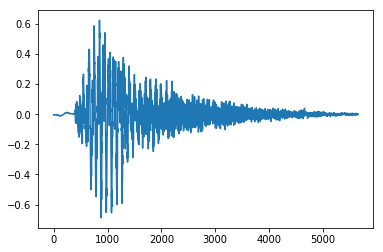

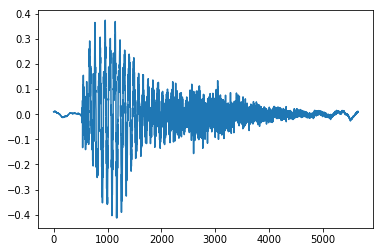

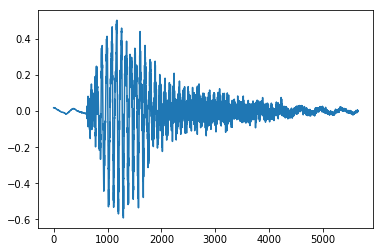

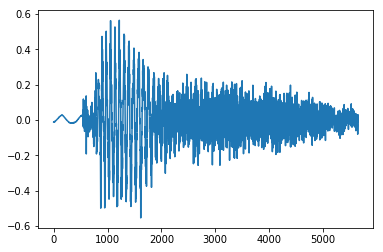

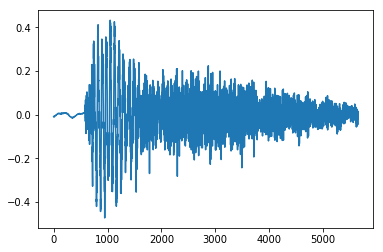

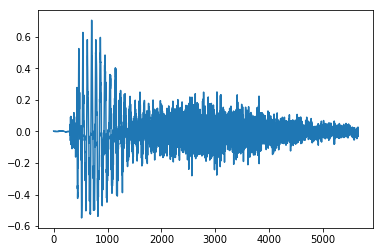

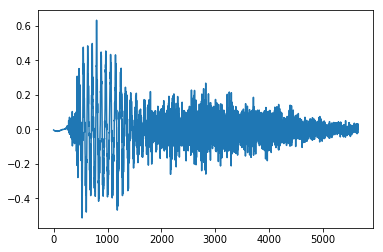

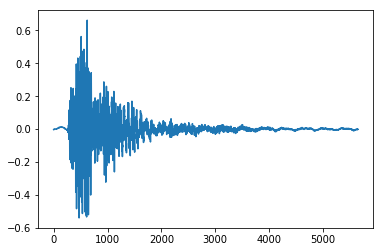

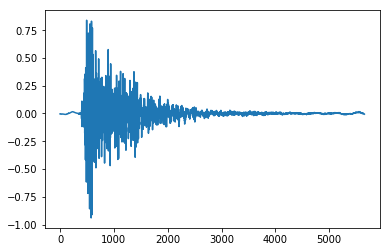

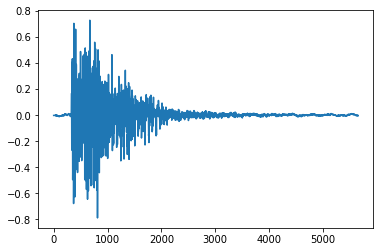

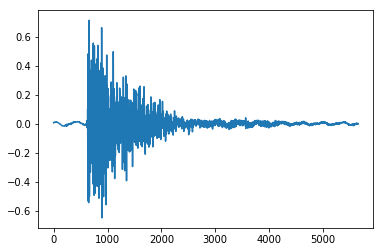

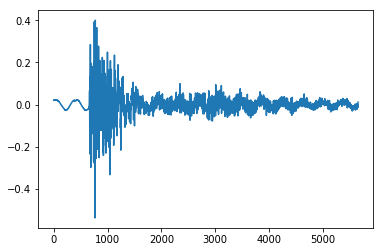

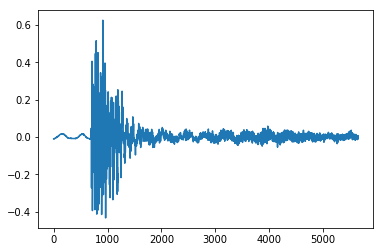

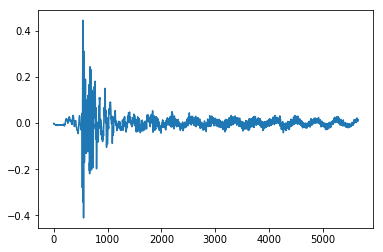

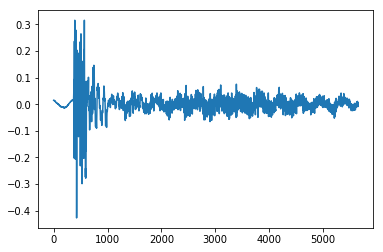

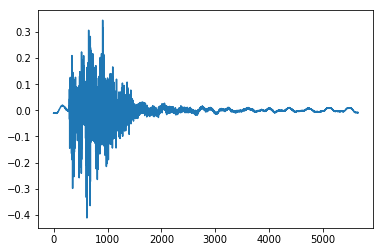

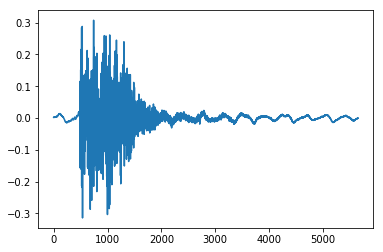

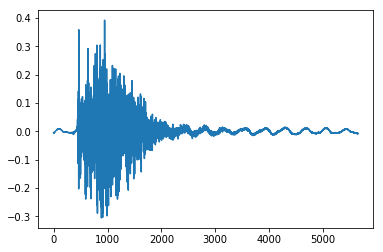

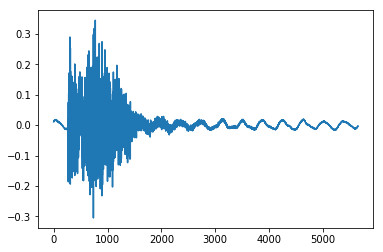

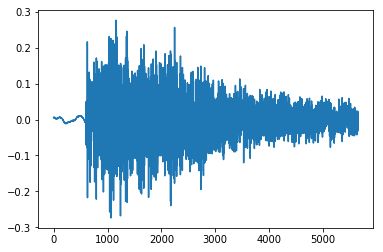

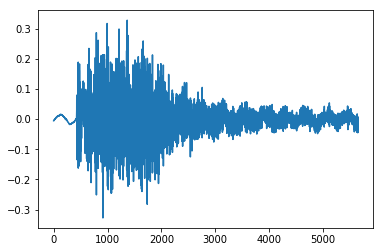

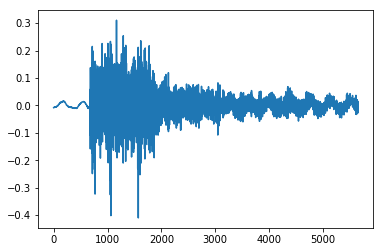

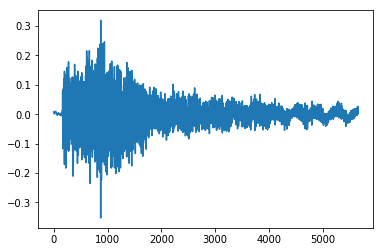

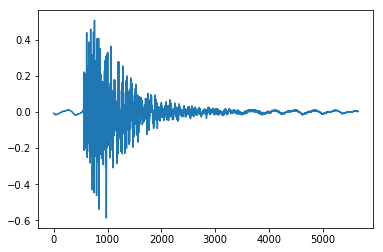

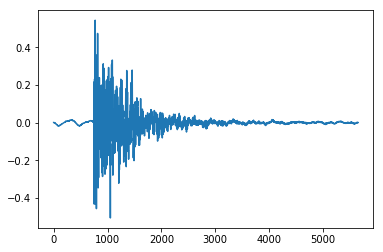

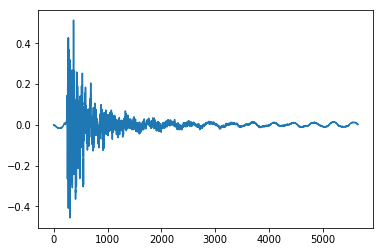

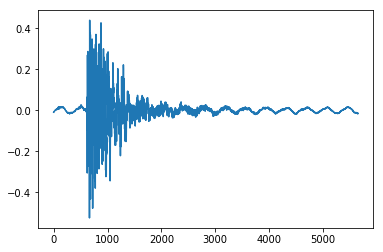

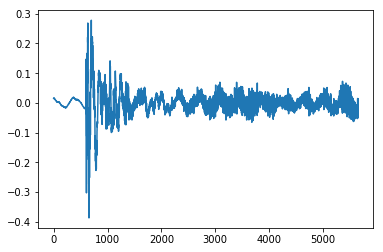

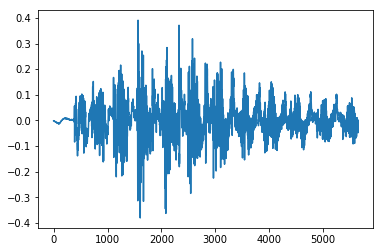

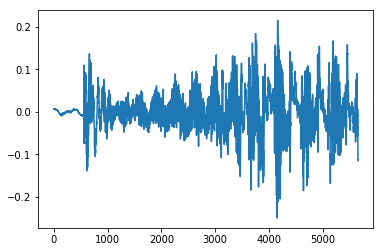

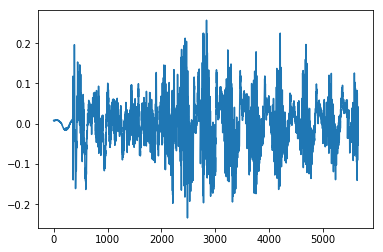

In [79]:
# #Visualization, playing around with data
# print("Number of observations: ", obsvArray.shape[1]+1)
# plt.figure(1)
# plt.plot(audio)
# plt.show()

#set observation index
for obsv_idx in range(obsvArray.shape[1]):
    plt.figure(obsv_idx)
    plt.plot(obsvArray[:,obsv_idx])
    plt.show()

# plt.figure(3)
# plt.imshow(Smag, origin = 'lower', cmap = 'jet')